In [34]:
using LinearAlgebra                                                             
using Test                                                                                       
using Distributions                                                             
using DataFrames                                                                          
using CSV                                                                              
using Polynomials  
using Roots
using Plots
using StatsFuns
using Pkg
                                                                                 
include("../computation/finitedifference.jl")                                                   
include("../quadrature/quadrature.jl")                                             
include("../transforms/transforms.jl")                                             
include("../priors/priors.jl")                                                     
include("../bayesopt/incremental.jl")                                              
include("../kernels/kernel.jl")                                                    
include("../datastructs.jl")                                                       
include("../computation/buffers0.jl") #datastruct, kernel, incremental, quadrature 
include("../model0.jl") #buffers, datastructs, several auxiliary  
# include("../model_MC.jl") #buffers, datastructs, several auxiliary                   
include("../computation/tdist.jl") #model0 and buffer0  


compute_BO_derivs

In [22]:
function covariate_fun(x, p)
    n = size(x, 1)
    d = size(x, 2)
    if p == 1
        return ones(n, 1)
    elseif p == 1 + d
        return hcat(ones(n), x)
    else
         throw(ArgumentError("Only support constant or linear convariate."))
    end
end

covariate_fun (generic function with 1 method)

In [3]:
# Data and setup for different tests

# choice of covariate functions
p = 1
p = 2

# training
x1 = [0., .5, .8, 1., 1.6, 2.]
x2 = [0., .5, .8, 1., 2.]
x3 = [0., .8, 1., 1.6, 2.]
x4 = [0., 1., 1.6, 2.]

# testing
x01 = .25
x02 = 1.2
x03 = .5
x04 = .6

# underlying 1d function
test_fun1(x) = sin(x) + 1.1
test_fun2(x) = sin(15*x) + (x^2+1) 
test_fun3(x) = log(x^2+1) + (x^3+x+1)/(exp(x)) 

test_fun3 (generic function with 1 method)

# Summary
**Settings parameters**: \
p: choices of covariates, p = 1 if constant and p = 2 if linear \
x: training data \
x0: testing data
test_fun: underlying function

**Tests**:
1. p=1 or p=2, x=x1, x0=x01, test_fun=test_fun1 \
    narrow pdf, some quantile comp hard ==> bracketing interval $[0,5]$ works well!
2. p=1, x2, x02, test_fun2 \
    pdf very large near 0, so 2.5% quantile estimation gives negative estimate, which is not a good guess and also indicates that 2.5% quantile is extremely small. 
3. p=1, x3, x03, test_fun3 \
    narrow pdf, median hard ==> bracketing interval $[0,5]$ works well! \
    cdf(0) = 0.02898, 2.5% quantile doesn't exist
4. p=1, x4, x04, test_fun1 \
    two-peak pdf, can do mode, some quantile, but two-peak makes computation of CI (equal and narrow) super hard.
    
**Conclusion**:
1. Narrow pdf is the hardest case. Even if quant0 provides relatively good initial guess, find_zero easily goes to negative region, where CDF is not defined. \
Solution: bracketing interval works better than initial guess in root-finding
2. cdf(0) > 2.5% makes 2.5% quantile doesn't exist          
3. Weird shape: large pdf near 0 and two-peak pdf should be carefully treated. 
 

In [4]:
p = 1 # choose covariate basis function, only support 1 or 1+dim(x)
x = x3 # choose training data 
x0 = x03 # choose testing data
test_fun = test_fun1 # choose underlying function

x = reshape(x, size(x, 1), 1)
x0 = reshape([x0], 1, 1) 
Fx = covariate_fun(x, p)
y = reshape(test_fun.(x), size(x, 1))
ymax = maximum(y)
y /= ymax
trainingData1 = trainingData(x, Fx, y) 

Fx0 = covariate_fun(x0, p)
y0_true = reshape(test_fun.(x0), 1)./ymax
println("Prediction at x0 = $x0")
println("Covariates at x0: $Fx0")
println("Should expect peak near $y0_true")

Prediction at x0 = [0.5]
Covariates at x0: [1.0]
Should expect peak near [0.752260142876725]


In [53]:
d = getDimension(trainingData1)
n = getNumPts(trainingData1)
p = getCovDimension(trainingData1)
rangeθ = [0.25 100]
rangeλ = [0.5 5]
type1 = ["MonteCarlo", "MonteCarlo"]
transform = BoxCox()
corr = Gaussian()
btg1 = btg(trainingData1, rangeθ, rangeλ; quadtype = type1)
weightTensorGrid = weight_comp(btg1)
pdf1, cdf1, dpdf1, quantInfo1 = solve(btg1);

In [43]:
btg2 = btg(trainingData1, rangeθ, rangeλ)
weightTensorGrid2 = weight_comp(btg2)
pdf2, cdf2, dpdf2, quantInfo2 = solve(btg2);

In [44]:
btg3 = btg(trainingData1, rangeθ, rangeλ; quadtype = ["MonteCarlo", "Gaussian"])
weightTensorGrid3 = weight_comp(btg3)
pdf3, cdf3, dpdf3, quantInfo3 = solve(btg3);

In [47]:
btg4 = btg(trainingData1, rangeθ, rangeλ; quadtype = ["SparseGrid", "Gaussian"])
weightTensorGrid4 = weight_comp(btg4)
pdf4, cdf4, dpdf4, quantInfo4 = solve(btg4);

  Building GR → `~/.julia/packages/GR/yMV3y/deps/build.log`


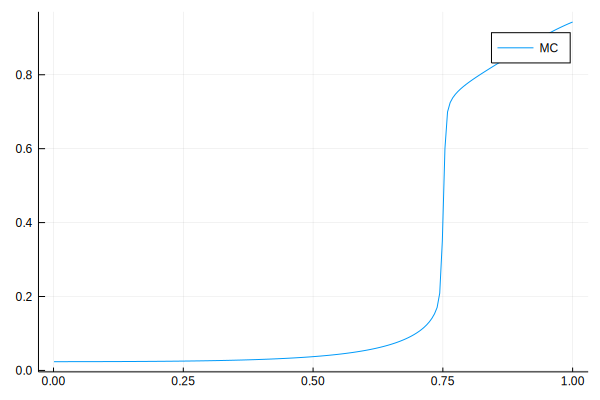

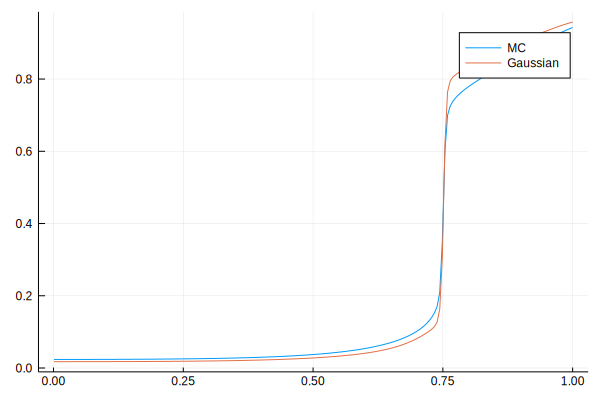

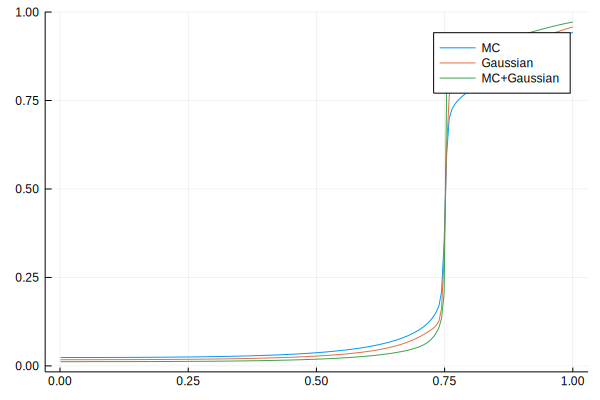

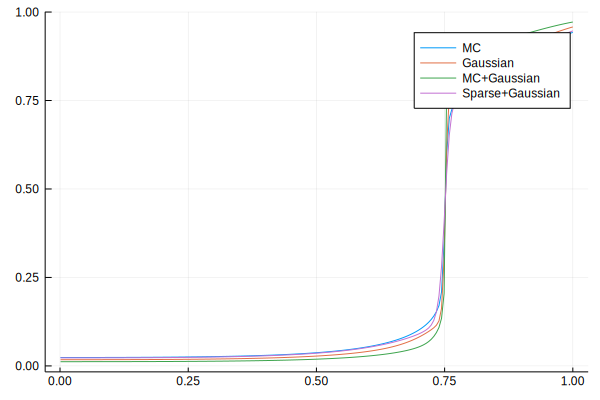

([0.001, 0.006020100502512562, 0.011040201005025126, 0.016060301507537688, 0.02108040201005025, 0.026100502512562813, 0.03112060301507538, 0.03614070351758794, 0.0411608040201005, 0.046180904522613066  …  0.954819095477387, 0.9598391959798995, 0.9648592964824121, 0.9698793969849246, 0.9748994974874372, 0.9799195979899498, 0.9849396984924623, 0.9899597989949749, 0.9949798994974874, 1.0], [0.022587252455989536, 0.022592226561435207, 0.022597581499743655, 0.022603498583285617, 0.02261001211914616, 0.02261714303343838, 0.02262491077447721, 0.022633335656246846, 0.022642439406084493, 0.02265224526871694  …  0.9190520226911486, 0.9224706988929443, 0.925811845283016, 0.9290715705137388, 0.9322462658889427, 0.9353326548646301, 0.938327836187972, 0.941229319674685, 0.9440350538896909, 0.9467434452804379])

In [54]:
ENV["GRDIR"]=""
Pkg.build("GR")
using Plots
# Plot to see the shape of pdf and cdf
dpdf_fixed1 = y0 -> dpdf1(x0, Fx0, y0) 
pdf_fixed1 = y0 -> pdf1(x0, Fx0, y0)
cdf_fixed1 = y0 -> cdf1(x0, Fx0, y0)
dpdf_fixed2 = y0 -> dpdf2(x0, Fx0, y0) 
pdf_fixed2 = y0 -> pdf2(x0, Fx0, y0)
cdf_fixed2 = y0 -> cdf2(x0, Fx0, y0)
dpdf_fixed3 = y0 -> dpdf3(x0, Fx0, y0) 
pdf_fixed3 = y0 -> pdf3(x0, Fx0, y0)
cdf_fixed3 = y0 -> cdf3(x0, Fx0, y0)
dpdf_fixed4 = y0 -> dpdf4(x0, Fx0, y0) 
pdf_fixed4 = y0 -> pdf4(x0, Fx0, y0)
cdf_fixed4 = y0 -> cdf4(x0, Fx0, y0)
a = 1e-3; b = 1.
plt(cdf_fixed1, a, b, 200, label = "MC")
plt!(cdf_fixed2, a, b, 200, label = "Gaussian")
plt!(cdf_fixed3, a, b, 200, label = "MC+Gaussian")
plt!(cdf_fixed4, a, b, 200, label = "Sparse+Gaussian")

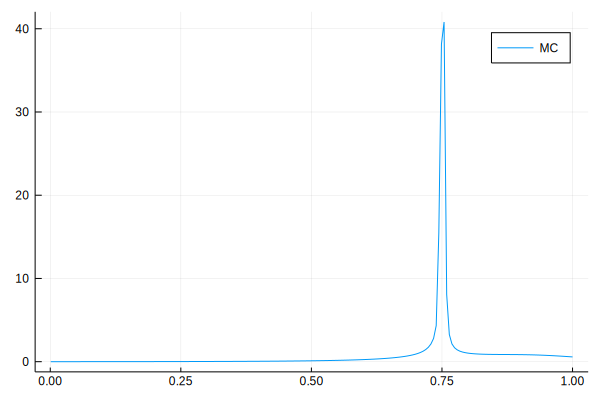

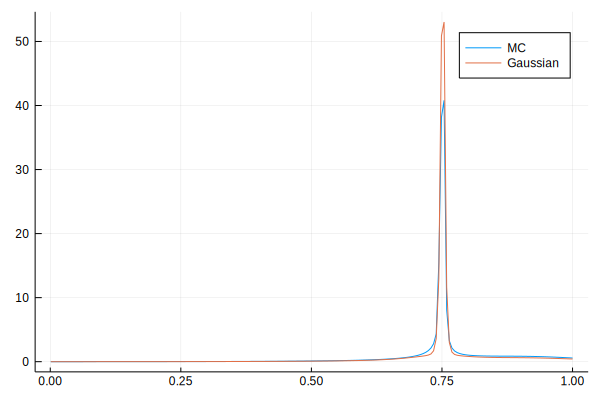

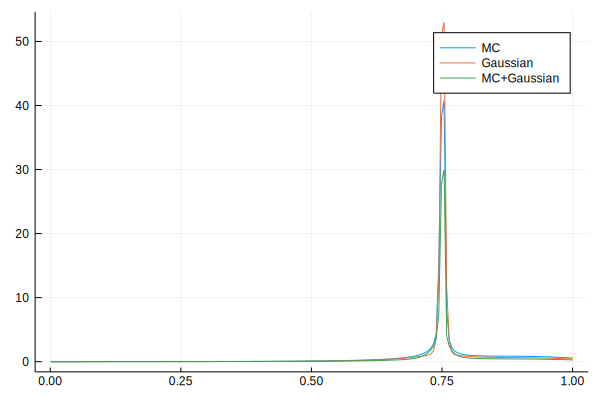

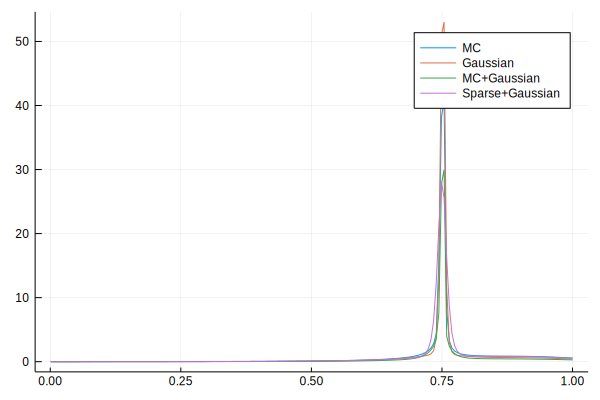

([0.001, 0.006020100502512562, 0.011040201005025126, 0.016060301507537688, 0.02108040201005025, 0.026100502512562813, 0.03112060301507538, 0.03614070351758794, 0.0411608040201005, 0.046180904522613066  …  0.954819095477387, 0.9598391959798995, 0.9648592964824121, 0.9698793969849246, 0.9748994974874372, 0.9799195979899498, 0.9849396984924623, 0.9899597989949749, 0.9949798994974874, 1.0], [0.0010323897446289415, 0.0010155830096377143, 0.0011210271506331667, 0.0012373132298717556, 0.0013583384157475713, 0.001483246357585121, 0.0016120822718140454, 0.0017450982470328504, 0.0018825929098124036, 0.002024868839088298  …  0.6884491884223474, 0.6734089780683082, 0.6575690182815545, 0.6409803196960306, 0.6237043086669655, 0.6058116757441078, 0.5873810004885255, 0.5684972026291337, 0.549249874673293, 0.5297315537695136])

In [55]:
plt(pdf_fixed1, a, b, 200, label = "MC")
plt!(pdf_fixed2, a, b, 200, label = "Gaussian")
plt!(pdf_fixed3, a, b, 200, label = "MC+Gaussian")
plt!(pdf_fixed4, a, b, 200, label = "Sparse+Gaussian")

# Quantile computation

In [56]:
include("test_quantile.jl")
include("../statistics.jl")

credible_interval (generic function with 3 methods)

In [58]:
# preprocess output from solve(btg)
pdf_fixed1, cdf_fixed1, dpdf_fixed1, quant01, support1 = pre_process(x0, Fx0, pdf1, cdf1, dpdf1, quantInfo1[1]);
pdf_fixed2, cdf_fixed2, dpdf_fixed2, quant02, support2 = pre_process(x0, Fx0, pdf2, cdf2, dpdf2, quantInfo2[1]);
pdf_fixed3, cdf_fixed3, dpdf_fixed3, quant03, support3 = pre_process(x0, Fx0, pdf3, cdf3, dpdf3, quantInfo3[1]);
pdf_fixed4, cdf_fixed4, dpdf_fixed4, quant04, support4 = pre_process(x0, Fx0, pdf4, cdf4, dpdf4, quantInfo4[1]);

println("Estimated support of pdf: $support")
println("MC: $support")
println("Gaussian: $support2")
println("MonteCarlo + Gaussian: $support3")
println("SparseGrid + Gaussian: $support4")

Estimated support of pdf: support
MC: support
Gaussian: [0.001, 5.0]
MonteCarlo + Gaussian: [0.001, 5.0]
SparseGrid + Gaussian: [0.001, 5.0]


In [59]:
DistributionInfo1 = summary_comp(pdf_fixed1, cdf_fixed1, dpdf_fixed1, quant01, support1; px = .8)

(quantile = (level = 0.8, value = 0.821364881027592, error = 0.0), median = (value = 0.7520381201454381, error = 1.1102230246251565e-15), mode = 0.7519106369280161, CIequal = (equal = [0.23154081610238628, 1.078015819667838], error = 1.1686558153949016e-16), CInarrow = nothing)

In [60]:
DistributionInfo2 = summary_comp(pdf_fixed2, cdf_fixed2, dpdf_fixed2, quant02, support2; px = .8)

(quantile = (level = 0.8, value = 0.7662508524858123, error = 0.0), median = (value = 0.7520702510511227, error = 9.992007221626409e-15), mode = 0.7516625543907569, CIequal = (equal = [0.4597959620802885, 1.0499030392881565], error = 0.0), CInarrow = nothing)

In [63]:
DistributionInfo3 = summary_comp(pdf_fixed3, cdf_fixed3, dpdf_fixed3, quant03, support3; px = .8)

InterruptException: InterruptException:

In [62]:
DistributionInfo4 = summary_comp(pdf_fixed4, cdf_fixed4, dpdf_fixed4, quant04, support4; px = .8)

(quantile = (level = 0.8, value = 0.8061367393503872, error = 0.0), median = (value = 0.7523111349684419, error = 1.1102230246251565e-15), mode = 0.7503309997192464, CIequal = (equal = [0.2967888423187095, 1.0717968087928544], error = 0.0), CInarrow = nothing)